<a href="https://colab.research.google.com/github/juankuntz/langevin_particle_autoencoders/blob/master/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
# Load drive:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab

In [2]:
# Import github repo:
import sys
!rm -rf langevin_particle_autoencoders
!git clone https://github.com/juankuntz/langevin_particle_autoencoders.git  
REPOSITORY_PATH = '/content/langevin_particle_autoencoders'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

Cloning into 'langevin_particle_autoencoders'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 80 (delta 28), reused 63 (delta 17), pack-reused 0
Unpacking objects: 100% (80/80), 154.89 KiB | 4.84 MiB/s, done.


In [3]:
# Import modules:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from langevin_particle_autoencoders.src import models, decoders

# Model training

To start, let's load the first $10,000$ images of the MNIST dataset to train our model with:

In [4]:
(x, _), (_, _) = tf.keras.datasets.mnist.load_data()
x = x[:10000].astype('float32')[..., np.newaxis]
data = tf.data.Dataset.from_tensor_slices(x)

11490434/11490434 [==============================] - 2s 0us/step


Next, let's define the model, starting with the decoder (taken from [here](https://keras.io/examples/generative/vae/)):

In [12]:
latent_dimensions = 32  
decoder = decoders.get_simple_decoder(latent_dimensions)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                           

We can now define the entire model:

In [13]:
lpae = models.LangevinParticleAutoencoder(latent_dimensions=latent_dimensions,
                                          decoder=decoder,
                                          observation_noise_std=1e-2)

To train it we use:
- $10$ particles,
- a step size of $0.0005$ to update the latent variables,
- and an RMSProp optimizer to update the decoder's parameters.

The decoder's final layer uses a sigmoid activation function, and, so, maps to $[0,1]^{28\times28}$. Hence, we normalize the data so that it lies in $[0,1]^{28\times28}$. This is handled internally via the the `preprocessor` and `postprocessor` arguments (the former normalizes, and that latter undoes it):

In [14]:
lpae.compile(lv_learning_rate=1e-3/2, n_particles=10,
             optimizer=tf.keras.optimizers.RMSprop(),
             preprocessor=tf.keras.layers.Rescaling(scale=1./255),
             postprocessor=tf.keras.layers.Rescaling(scale=255.))

Train model:

In [15]:
history = lpae.fit(data=data, epochs=100, batch_size=256)  

Epoch 1/100
39/39 [==============================] - 7s 106ms/step - loss: 358121.5934
Epoch 2/100
39/39 [==============================] - 4s 107ms/step - loss: 253218.4609
Epoch 3/100
39/39 [==============================] - 4s 114ms/step - loss: 207104.7258
Epoch 4/100
39/39 [==============================] - 4s 111ms/step - loss: 161741.3332
Epoch 5/100
39/39 [==============================] - 4s 106ms/step - loss: 129179.0582
Epoch 6/100
39/39 [==============================] - 4s 107ms/step - loss: 105402.1059
Epoch 7/100
39/39 [==============================] - 4s 107ms/step - loss: 86879.6076
Epoch 8/100
39/39 [==============================] - 4s 107ms/step - loss: 73617.1308
Epoch 9/100
39/39 [==============================] - 4s 108ms/step - loss: 64195.4134
Epoch 10/100
39/39 [==============================] - 4s 108ms/step - loss: 56537.8044
Epoch 11/100
39/39 [==============================] - 4s 108ms/step - loss: 51017.9402
Epoch 12/100
39/39 [==========================

# Visualize posterior

In [16]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None):
  images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
  if not names:
    names = ['' for _ in images]
  grid_size = math.ceil(len(images) ** (1/2))
  for i, (image, name) in enumerate(zip(images, names)):
      ax = plt.subplot(grid_size, grid_size, i + 1)
      ax.set_title(name)
      plt.imshow(255 - image.astype("uint8"), cmap='Greys')
      plt.axis("off")
  plt.gcf().tight_layout()    
  plt.show()

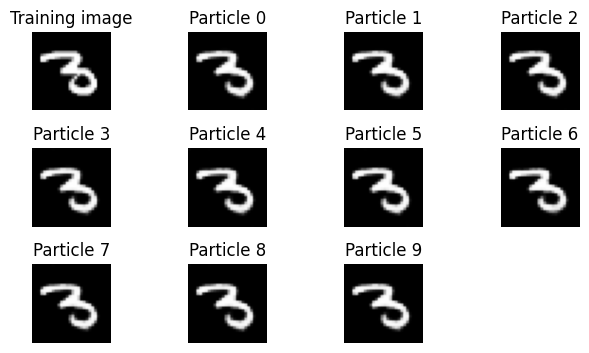

In [17]:
i, n_samples = 30, 10
samples = lpae.decode_posterior_samples(n_samples=n_samples, index=i)
names = ['Training image'] + [f'Particle {i}' for i in range(n_samples)]
plot_images(tf.concat([x[[i], ...], samples], axis=0), names)

# Generate fakes

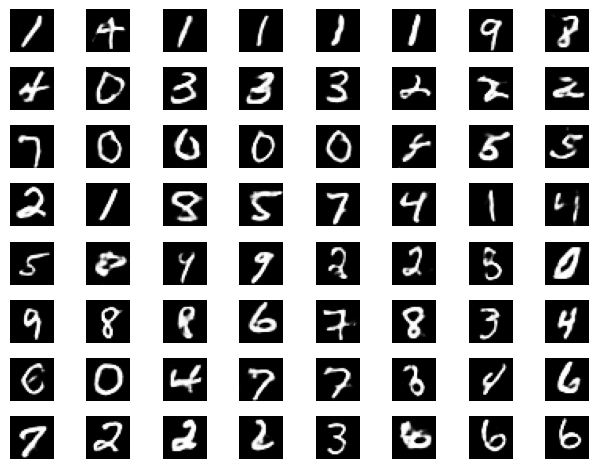

In [20]:
fakes = lpae.generate_fakes(n_fakes=64)
plot_images(fakes)